# Chapter 14: Association Rules and Collaborative Filtering

## Import required packages

In [1]:
# need to run "pip install mlxtend" first
# need to run "pip install surprise" first
# "conda install -c conda-forge scikit-surprise" in "terminal" (Mac) or "Anaconda Prompt" (Windows)
%matplotlib inline

from pathlib import Path

import heapq
from collections import defaultdict

import pandas as pd
import matplotlib.pylab as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('/Users/min/OneDrive/teaching/DS110/dmba/')
#DATA = Path('C:/Users/Min Li/OneDrive/teaching/DS110/dmba')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

## Table 14.4

In [6]:
# Load and preprocess data set 
fp_df = pd.read_csv(DATA / 'Faceplate.csv')
fp_df

,Transaction,Red,White,Blue,Orange,Green,Yellow
0,1,1,1,0,0,1,0
1,2,0,1,0,1,0,0
2,3,0,1,1,0,0,0
3,4,1,1,0,1,0,0
4,5,1,0,1,0,0,0
5,6,0,1,1,0,0,0
6,7,1,0,1,0,0,0
7,8,1,1,1,0,1,0
8,9,1,1,1,0,0,0
9,10,0,0,0,0,0,1


In [7]:
fp_df.set_index('Transaction', inplace=True)
print(fp_df)

             Red  White  Blue  Orange  Green  Yellow
Transaction                                         
1              1      1     0       0      1       0
2              0      1     0       1      0       0
3              0      1     1       0      0       0
4              1      1     0       1      0       0
5              1      0     1       0      0       0
6              0      1     1       0      0       0
7              1      0     1       0      0       0
8              1      1     1       0      1       0
9              1      1     1       0      0       0
10             0      0     0       0      0       1


In [8]:
# create frequent itemsets
itemsets = apriori(fp_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

/Users/min/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,"(Red, White)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
15,(Green),"(Red, White)",0.2,0.4,0.2,1.0,2.500000,0.12,inf
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
14,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


In [9]:
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

       antecedents   consequents  support  confidence      lift  leverage
13    (Red, White)       (Green)      0.2         0.5  2.500000      0.12
15         (Green)  (Red, White)      0.2         1.0  2.500000      0.12
4          (Green)         (Red)      0.2         1.0  1.666667      0.08
14  (White, Green)         (Red)      0.2         1.0  1.666667      0.08
7         (Orange)       (White)      0.2         1.0  1.428571      0.06
8          (Green)       (White)      0.2         1.0  1.428571      0.06


In [10]:
# filter to get rules with single consequents only
rules[[len(c) == 1 for c in rules.consequents]].sort_values(by=['lift'], ascending=False).head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,"(Red, White)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
14,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
12,"(Red, Green)",(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


The apriori method accepts sparse data frames as well. If we convert the original data frame to sparse format, we can see that the memory requirements go down to 40%. The `fill_value` argument informs the `to_sparse` method here which fields to ignore in each transaction.

In [11]:
# Convert data set into a sparse data frame
#sparse_df = fp_df.to_sparse(fill_value=0)
# print('Density {}'.format(sparse_df.density))
sparse_df = fp_df.astype(pd.SparseDtype(int, fill_value=0))
sparse_df.dtypes

Red       Sparse[int64, 0]
White     Sparse[int64, 0]
Blue      Sparse[int64, 0]
Orange    Sparse[int64, 0]
Green     Sparse[int64, 0]
Yellow    Sparse[int64, 0]
dtype: object

In [12]:
# create frequent itemsets
itemsets = apriori(sparse_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

/Users/min/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,"(Red, White)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
15,(Green),"(Red, White)",0.2,0.4,0.2,1.0,2.500000,0.12,inf
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
14,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


In [13]:
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

       antecedents   consequents  support  confidence      lift  leverage
13    (Red, White)       (Green)      0.2         0.5  2.500000      0.12
15         (Green)  (Red, White)      0.2         1.0  2.500000      0.12
4          (Green)         (Red)      0.2         1.0  1.666667      0.08
14  (White, Green)         (Red)      0.2         1.0  1.666667      0.08
7         (Orange)       (White)      0.2         1.0  1.428571      0.06
8          (Green)       (White)      0.2         1.0  1.428571      0.06


## Data required for Table 14.5 and 14.6

In [14]:
# Prepare the dataset for table 14.6 based on table 14.5
from itertools import chain
randomTransactions = [{8}, {3,4,8}, {8}, {3,9}, {9}, {1,8}, {6,9}, {3,5,7,9}, {8}, set(), 
                      {1,7,9}, {1,4,5,8,9}, {5,7,9}, {6,7,8}, {3,7,9}, {1,4,9}, {6,7,8}, {8}, set(), {9},
                      {2,5,6,8}, {4,6,9}, {4,9}, {8,9}, {6,8}, {1,6,8}, {5,8}, {4,8,9}, {9}, {8},
                      {1,5,8}, {3,6,9}, {7,9}, {7,8,9}, {3,4,6,8}, {1,4,8}, {4,7,8}, {8,9}, {4,5,7,9}, {2,8,9},
                      {2,5,9}, {1,2,7,9}, {5,8}, {1,7,8}, {8}, {2,7,9}, {4,6,9}, {9}, {9}, {6,7,8}]
print(randomTransactions)
uniqueItems = sorted(set(chain.from_iterable(randomTransactions)))
randomData = pd.DataFrame(0, index=range(len(randomTransactions)), columns=uniqueItems)
for row, transaction in enumerate(randomTransactions):
    for item in transaction:
        randomData.loc[row][item] = 1
randomData.head()

[{8}, {8, 3, 4}, {8}, {9, 3}, {9}, {8, 1}, {9, 6}, {9, 3, 5, 7}, {8}, set(), {1, 9, 7}, {1, 4, 5, 8, 9}, {9, 5, 7}, {8, 6, 7}, {9, 3, 7}, {1, 4, 9}, {8, 6, 7}, {8}, set(), {9}, {8, 2, 5, 6}, {9, 4, 6}, {9, 4}, {8, 9}, {8, 6}, {8, 1, 6}, {8, 5}, {8, 9, 4}, {9}, {8}, {8, 1, 5}, {9, 3, 6}, {9, 7}, {8, 9, 7}, {8, 3, 4, 6}, {8, 1, 4}, {8, 4, 7}, {8, 9}, {9, 4, 5, 7}, {8, 9, 2}, {9, 2, 5}, {1, 2, 9, 7}, {8, 5}, {8, 1, 7}, {8}, {9, 2, 7}, {9, 4, 6}, {9}, {9}, {8, 6, 7}]


,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


## Table 14.6

In [15]:
# create frequent itemsets
itemsets = apriori(randomData, min_support=2/len(randomData), use_colnames=True)
# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.7)
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

  antecedents consequents  support  confidence      lift  leverage
3      (8, 3)         (4)     0.04         1.0  4.545455    0.0312
1      (1, 5)         (8)     0.04         1.0  1.851852    0.0184
2      (2, 7)         (9)     0.04         1.0  1.851852    0.0184
4      (3, 4)         (8)     0.04         1.0  1.851852    0.0184
5      (3, 7)         (9)     0.04         1.0  1.851852    0.0184
6      (4, 5)         (9)     0.04         1.0  1.851852    0.0184


/Users/min/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


## Table 14.8

In [16]:
# load dataset
all_books_df = pd.read_csv(DATA / 'CharlesBookClub.csv')

# create the binary incidence matrix
ignore = ['Seq#', 'ID#', 'Gender', 'M', 'R', 'F', 'FirstPurch', 'Related Purchase',
          'Mcode', 'Rcode', 'Fcode', 'Yes_Florence', 'No_Florence']
count_books = all_books_df.drop(columns=ignore)
count_books[count_books > 0] = 1

count_books.head()

,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Florence
0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


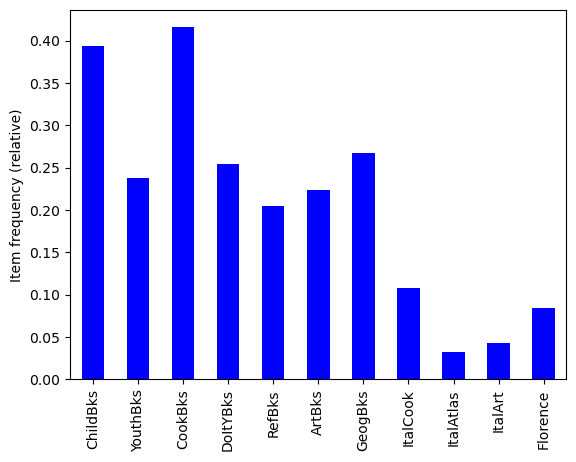

In [17]:
# determine item frequencies
itemFrequency = count_books.sum(axis=0) / len(count_books)

# and plot as histogram
ax = itemFrequency.plot.bar(color='blue')
plt.ylabel('Item frequency (relative)')
plt.show()

In [18]:
# create frequent itemsets and rules
itemsets = apriori(count_books, min_support=200/4000, use_colnames=True)
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)

print('Number of rules', len(rules))

# Display 25 rules with highest lift
rules.sort_values(by=['lift'], ascending=False).head(25)

pd.set_option('display.width', 100)
pd.set_option('display.precision',5)

print(rules.sort_values(by=['lift'], ascending=False).drop(columns=['antecedent support', 'consequent support', 'conviction']).head(25))
#pd.set_option('precision', 6)
pd.reset_option('display.width')
pd.reset_option('display.precision')

Number of rules 81
                      antecedents          consequents  support  confidence     lift  leverage
64             (RefBks, YouthBks)  (ChildBks, CookBks)  0.05525     0.68000  2.80992   0.03559
73             (RefBks, DoItYBks)  (ChildBks, CookBks)  0.06125     0.66216  2.73621   0.03886
60           (YouthBks, DoItYBks)  (ChildBks, CookBks)  0.06700     0.64891  2.68145   0.04201
80              (GeogBks, RefBks)  (ChildBks, CookBks)  0.05025     0.61468  2.54000   0.03047
69            (GeogBks, YouthBks)  (ChildBks, CookBks)  0.06325     0.60526  2.50109   0.03796
77            (GeogBks, DoItYBks)  (ChildBks, CookBks)  0.06050     0.59901  2.47525   0.03606
65   (GeogBks, ChildBks, CookBks)           (YouthBks)  0.06325     0.57763  2.42445   0.03716
70    (RefBks, ChildBks, CookBks)           (DoItYBks)  0.06125     0.59179  2.32301   0.03488
48            (GeogBks, DoItYBks)           (YouthBks)  0.05450     0.53960  2.26486   0.03044
61    (RefBks, ChildBks, CookBk

/Users/min/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [19]:
# Filter rules by number of antecedents (maximum 2) and consequents (maximum 1)
rules = rules[[len(c) <= 2 for c in rules.antecedents]]
rules = rules[[len(c) == 1 for c in rules.consequents]]

rules.sort_values(by=['lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
48,"(GeogBks, DoItYBks)",(YouthBks),0.10100,0.23825,0.05450,0.539604,2.264864,0.030437,1.654554
33,"(RefBks, ChildBks)",(DoItYBks),0.12825,0.25475,0.07100,0.553606,2.173135,0.038328,1.669490
19,"(GeogBks, ChildBks)",(YouthBks),0.14625,0.23825,0.07550,0.516239,2.166797,0.040656,1.574642
45,"(GeogBks, CookBks)",(YouthBks),0.15625,0.23825,0.08025,0.513600,2.155719,0.043023,1.566098
16,"(ChildBks, YouthBks)",(DoItYBks),0.14750,0.25475,0.08025,0.544068,2.135693,0.042674,1.634563
50,"(RefBks, CookBks)",(DoItYBks),0.13975,0.25475,0.07450,0.533095,2.092619,0.038899,1.596148
22,"(ChildBks, CookBks)",(DoItYBks),0.24200,0.25475,0.12775,0.527893,2.072198,0.066101,1.578560
47,"(GeogBks, YouthBks)",(DoItYBks),0.10450,0.25475,0.05450,0.521531,2.047227,0.027879,1.557573
41,"(YouthBks, CookBks)",(DoItYBks),0.16100,0.25475,0.08375,0.520186,2.041948,0.042735,1.553207
43,"(RefBks, YouthBks)",(CookBks),0.08125,0.41550,0.06825,0.840000,2.021661,0.034491,3.653125


## Section 14.2 Collaborative Filtering

In [19]:
ratings = pd.DataFrame([
    [30878, 1, 4], [30878, 5, 1], [30878, 18, 3], [30878, 28, 3], [30878, 30, 4], [30878, 44, 5], 
    [124105, 1, 4], 
    [822109, 1, 5], 
    [823519, 1, 3], [823519, 8, 1], [823519, 17, 4], [823519, 28, 4], [823519, 30, 5], 
    [885013, 1, 4], [885013, 5, 5], 
    [893988, 1, 3], [893988, 30, 4], [893988, 44, 4], 
    [1248029, 1, 3], [1248029, 28, 2], [1248029, 30, 4], [1248029, 48, 3], 
    [1503895, 1, 4], 
    [1842128, 1, 4], [1842128, 30, 3], 
    [2238063, 1, 3], 
], columns=['customerID', 'movieID', 'rating'])
ratings

,customerID,movieID,rating
0,30878,1,4
1,30878,5,1
2,30878,18,3
3,30878,28,3
4,30878,30,4
5,30878,44,5
6,124105,1,4
7,822109,1,5
8,823519,1,3
9,823519,8,1


In [20]:
# https://surprise.readthedocs.io/en/stable/reader.html
# The Reader class is used to parse a file containing ratings.
# Such a file is assumed to specify only one rating per line, and each line needs to respect the following structure:
# user ; item ; rating ; [timestamp]
# rating_scale=(minimum_rating, maximum_rating)
reader = Reader(rating_scale=(1, 5))
reader

In [21]:
data = Dataset.load_from_df(ratings[['customerID', 'movieID', 'rating']], reader)
trainset = data.build_full_trainset() # https://surprise.readthedocs.io/en/stable/index.html
sim_options = {'name': 'cosine', 'user_based': False}  # compute cosine similarities between items
algo = KNNBasic(sim_options=sim_options) # https://surprise.readthedocs.io/en/stable/knn_inspired.html
algo.fit(trainset)
pred = algo.predict(str(823519), str(30), r_ui=5, verbose=True) # r_ui=5 is the true rating

Computing the cosine similarity matrix...
Done computing similarity matrix.
user: 823519     item: 30         r_ui = 5.00   est = 3.54   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [22]:
data = Dataset.load_from_df(ratings[['customerID', 'movieID', 'rating']], reader)
trainset = data.build_full_trainset() # https://surprise.readthedocs.io/en/stable/index.html
sim_options = {'name': 'pearson', 'user_based': False}  # compute cosine similarities between items
algo = KNNBasic(sim_options=sim_options) # https://surprise.readthedocs.io/en/stable/knn_inspired.html
algo.fit(trainset)
pred = algo.predict(str(823519), str(30), r_ui=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
user: 823519     item: 30         r_ui = 5.00   est = 3.54   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


## Table 14.11

In [23]:
import random

random.seed(0)
nratings = 5000
randomData = pd.DataFrame({
    'itemID': [random.randint(0,99) for _ in range(nratings)],
    'userID': [random.randint(0,999) for _ in range(nratings)],
    'rating': [random.randint(1,5) for _ in range(nratings)],
})
randomData

,itemID,userID,rating
0,49,665,1
1,97,974,5
2,53,542,5
3,5,634,3
4,33,694,2
...,...,...,...
4995,29,211,4
4996,93,901,5
4997,22,336,3
4998,46,584,3


In [24]:
def get_top_n(predictions, NumberOfItems):
    # First map the predictions to each user.
    byUser = defaultdict(list)
    for p in predictions:
        byUser[p.uid].append(p)
    
    # For each user, reduce predictions to top-n
    for uid, userPredictions in byUser.items():
        byUser[uid] = heapq.nlargest(NumberOfItems, userPredictions, key=lambda p: p.est)
    return byUser

## Table 14.12

In [25]:
# Convert thes data set into the format required by the surprise package
# The columns must correspond to user id, item id and ratings (in that order)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(randomData[['userID', 'itemID', 'rating']], reader)

# Split into training and test set
trainset, testset = train_test_split(data, test_size=.25, random_state=1)

## User-based filtering
# compute cosine similarity between users 
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
# Then predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)
NumberOfItems = 4
top_n = get_top_n(predictions, NumberOfItems)

In [27]:
NumberOfUsers=5
# Print the recommended items for each user
print()
print('Top-4 recommended items for each user')
for uid, user_ratings in list(top_n.items())[:NumberOfUsers]:
    print('User {}'.format(uid))
    for prediction in user_ratings:
        print('  Item {0.iid} ({0.est:.2f})'.format(prediction), end='')
    print()
print()


Top-4 recommended items for each user
User 6
  Item 6 (5.00)  Item 77 (2.50)  Item 60 (1.00)
User 222
  Item 77 (3.50)  Item 75 (2.78)
User 424
  Item 14 (3.50)  Item 45 (3.10)  Item 54 (2.34)
User 87
  Item 27 (3.00)  Item 54 (3.00)  Item 82 (3.00)  Item 32 (1.00)
User 121
  Item 98 (3.48)  Item 32 (2.83)



In [28]:
## Item-based filtering
# compute cosine similarity between users 
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)
NumberOfItems = 4
NumberOfUsers = 5

top_n = get_top_n(predictions, NumberOfItems)

# Print the recommended items for each user
print()
print('Top-n recommended items for each user')
for uid, user_ratings in list(top_n.items())[:NumberOfUsers]:
    print('User {}'.format(uid))
    for prediction in user_ratings:
        print('  Item {0.iid} ({0.est:.2f})'.format(prediction), end='')
    print()

Computing the cosine similarity matrix...
Done computing similarity matrix.

Top-n recommended items for each user
User 6
  Item 77 (3.00)  Item 60 (3.00)  Item 6 (3.00)
User 222
  Item 77 (2.24)  Item 75 (2.00)
User 424
  Item 54 (3.47)  Item 14 (3.44)  Item 45 (3.00)
User 87
  Item 27 (3.00)  Item 32 (3.00)  Item 82 (3.00)  Item 54 (2.50)
User 121
  Item 32 (3.06)  Item 98 (2.31)


In [29]:
## Build a model using the full dataset
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Predict rating for user 383 and item 7
algo.predict(383, 7)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Prediction(uid=383, iid=7, r_ui=None, est=2.3661840936304324, details={'actual_k': 4, 'was_impossible': False})

In [30]:
algo.predict(823519, 7)

Prediction(uid=823519, iid=7, r_ui=None, est=2.9912, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [31]:
# Python code to demonstrate the working of cos()
     
# importing "math" for mathematical operations 
import math 
    
a = math.pi / 2
     
# returning the value of cosine of pi / 2 
print ("The value of cosine of pi / 2 is : ", end ="") 
print (math.cos(a)) 

The value of cosine of pi / 2 is : 6.123233995736766e-17


In [32]:
math.cos(math.pi)

-1.0

In [33]:
math.cos(math.pi/2)

6.123233995736766e-17

In [34]:
math.cos(math.pi*0)

1.0